In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import PIL.Image as Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import models,transforms
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device)

cuda


In [3]:
path = "../input/aptos2019-blindness-detection/"
train_df = pd.read_csv(f"{path}train.csv")
print(f'No.of.training_samples: {len(train_df)}')

No.of.training_samples: 3662


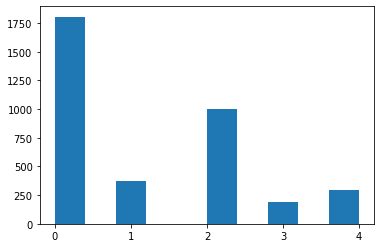

In [4]:
#Histogram of label counts.
train_df.diagnosis.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show() 

In [5]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['diagnosis'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)
print(class_weights) 

tensor([0.4058, 1.9795, 0.7331, 3.7948, 2.4827], device='cuda:0')


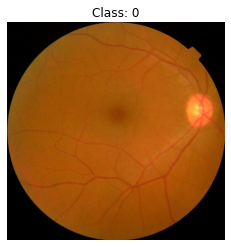

In [6]:
path = "../input/dr-aptos2019-preprocessed/"
num = int(np.random.randint(0,len(train_df)-1,(1,))) #Picks a random number.
sample_image = (f'{path}train_images/{train_df["id_code"][num]}.png')#Image file.
sample_image = Image.open(sample_image) 
plt.imshow(sample_image)
plt.axis('off')
plt.title(f'Class: {train_df["diagnosis"][num]}') #Class of the random image.
plt.show()

In [7]:
def one_hot(x):
    return torch.eye(5)[x,:]

In [8]:
class dataset(Dataset):
    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
        
    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.
    
    def __getitem__(self,index):
        image_id = self.df['id_code'][index]
        image = Image.open(f'{self.data_path}/{image_id}.png') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.
        
        if self.train :
            label = one_hot(self.df['diagnosis'][index]) #Label.
            return image,label #If train == True, return image & label.
        
        else:
            return image #If train != True, return image.
            

In [9]:
path="../input/dr-aptos2019-preprocessed/"
image_transform = transforms.Compose([transforms.Resize([512,512]),
                                     # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) #Transformations to apply to the image.
data_set = dataset(train_df,f'{path}train_images',image_transform=image_transform)

train_set,valid_set = torch.utils.data.random_split(data_set,[3302,360],generator=torch.Generator().manual_seed(989))

In [10]:
train_dataloader = DataLoader(train_set,batch_size=16,shuffle=True) #DataLoader for train_set.
valid_dataloader = DataLoader(valid_set,batch_size=16,shuffle=False) #DataLoader for validation_set.

In [11]:
model = models.resnet50()
model.fc=nn.Sequential(nn.Linear(2048,5),nn.Sigmoid())
model = model.to(device)

In [12]:
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score

def validate():
    model.eval()
    total = 0
    correct = 0
    running_loss = 0
    pred_lst = []
    gt_lst = []
    with torch.no_grad():
        for x,y in valid_dataloader:
            output= model(x.to(device)) #model's output.
            output=output.detach().cpu().numpy()
            #print(output)
            pred_lst.append(output)
            gt_lst.append(y)
            del x, y, output
            
        
        pred_lst=np.concatenate(pred_lst, axis=0)
        gt_lst=np.concatenate(gt_lst, axis=0)
        #print(pred_lst)
        #for i in range(len(gt_lst)):                     
            #print(np.mean(pred_lst[i][0],axis=0))
            #print(np.sum(pred_lst,axis=0))
        pred_lst2 = np.argmax(pred_lst, axis=1)
        #print(pred_lst2)
        #print("\n")
        gt_lst2 = np.argmax(gt_lst, axis=1)
        auc_lst=[]
        acc_lst=[]
        for k in range(0,5):
            tmp_gt=gt_lst[:, k]
            tmp_pred=pred_lst[:,k]
            tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
            acc_lst.append(tmp_acc)
            tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
            auc_lst.append(tmp_auc)

        auc_lst=np.array(auc_lst)
        acc_lst=np.array(acc_lst)
        print('AUC Classwise Score on Validation set = ', auc_lst)
        print('ACC Classwise Score on Validation set = ', acc_lst)
        auc=np.mean(auc_lst)
        acc = np.mean(acc_lst)
        print('AUC Score on Validation set = ', auc)
        print('ACC Score on Validation set = ', acc)
        f1 = f1_score(gt_lst2, pred_lst2, average='weighted')
        print('F1 Score on Validation set = ', f1)
        cohen_kappa = cohen_kappa_score(gt_lst2, pred_lst2,weights="quadratic")
        print("Cohen's Kappa Score on Validation set = ", cohen_kappa)
        print(classification_report(gt_lst2, pred_lst2, labels=[0,1, 2, 3,4]))
        model.train()
        return auc,acc,f1,cohen_kappa

In [13]:
def train():
    total_batches=len(train_dataloader)
    cycle_length= len(train_dataloader)*2
    loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss
    optimizer = torch.optim.SGD(model.parameters(),lr=0.001) 
    model.train()
    total = 0
    correct = 0
    running_loss=0
    count=0
    max_epochs=50
    
    
    for epoch in range(0, max_epochs):
        for batch,(x,y) in enumerate(train_dataloader):
            output = model(x.to(device)) #model's predictions.
            y=y.long()
            loss   = loss_fn(output,torch.max(y.to(device), 1)[1])
            running_loss=running_loss+loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (batch+1) % 25 == 0: # displays after every 20 batches
                    print ("Epoch [{}/{}], Batch [{}/{}] Classification Loss: {:.4f}".format(epoch+1, max_epochs, batch+1, total_batches, running_loss/(batch+1) ), end ="\r")
                    
            count=count+1
            if count>=cycle_length:
                count=0
                auc,acc,f1,cohen_kappa=validate()
                auc=np.round(auc,4)
                nm='DR_CNN_Model_RESENET50.pt_'+str(cohen_kappa)
                torch.save({'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict()}, nm)
                del nm
                running_loss=0
                
    return model

In [14]:
model=train()

AUC Classwise Score on Validation set =  [0.81305265 0.69726383 0.66464054 0.71263419 0.65815276]
ACC Classwise Score on Validation set =  [0.76388889 0.89722222 0.69166667 0.96111111 0.91111111]
AUC Score on Validation set =  0.7091487938649763
ACC Score on Validation set =  0.8450000000000001
F1 Score on Validation set =  0.4626391813891814
Cohen's Kappa Score on Validation set =  0.38212801620281456
              precision    recall  f1-score   support

           0       0.64      0.90      0.75       167
           1       0.00      0.00      0.00        37
           2       0.56      0.22      0.31       111
           3       0.00      0.00      0.00        14
           4       0.15      0.39      0.22        31

    accuracy                           0.52       360
   macro avg       0.27      0.30      0.26       360
weighted avg       0.48      0.52      0.46       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.86706897 0.75307506 0.71464235 0.76919901 0.67433082]
ACC Classwise Score on Validation set =  [0.80277778 0.85       0.69444444 0.96111111 0.85833333]
AUC Score on Validation set =  0.7556632412747797
ACC Score on Validation set =  0.8333333333333334
F1 Score on Validation set =  0.5309374073105773
Cohen's Kappa Score on Validation set =  0.3354271055596847
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       167
           1       0.25      0.51      0.34        37
           2       0.52      0.30      0.38       111
           3       0.00      0.00      0.00        14
           4       0.13      0.13      0.13        31

    accuracy                           0.55       360
   macro avg       0.33      0.36      0.33       360
weighted avg       0.54      0.55      0.53       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.88614998 0.76462221 0.72719708 0.76300578 0.67893911]
ACC Classwise Score on Validation set =  [0.81944444 0.65       0.67777778 0.96111111 0.64166667]
AUC Score on Validation set =  0.7639828311597696
ACC Score on Validation set =  0.75
F1 Score on Validation set =  0.49171927682854016
Cohen's Kappa Score on Validation set =  0.3222931435126629
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       167
           1       0.21      0.76      0.33        37
           2       0.39      0.20      0.26       111
           3       0.00      0.00      0.00        14
           4       0.10      0.03      0.05        31

    accuracy                           0.51       360
   macro avg       0.30      0.35      0.29       360
weighted avg       0.53      0.51      0.49       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.90352456 0.76328341 0.75096784 0.76899257 0.66874203]
ACC Classwise Score on Validation set =  [0.83888889 0.66388889 0.67777778 0.66388889 0.64166667]
AUC Score on Validation set =  0.7711020802626131
ACC Score on Validation set =  0.6972222222222222
F1 Score on Validation set =  0.5998141005215931
Cohen's Kappa Score on Validation set =  0.5360274946669827
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       167
           1       0.35      0.32      0.34        37
           2       0.50      0.74      0.59       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.64       360
   macro avg       0.34      0.37      0.35       360
weighted avg       0.58      0.64      0.60       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.90433123 0.76830391 0.73855783 0.77683732 0.67766448]
ACC Classwise Score on Validation set =  [0.83888889 0.60277778 0.66666667 0.59166667 0.575     ]
AUC Score on Validation set =  0.7731389555812207
ACC Score on Validation set =  0.655
F1 Score on Validation set =  0.5146608562831966
Cohen's Kappa Score on Validation set =  0.3736397368338997
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       167
           1       0.21      0.73      0.32        37
           2       0.43      0.25      0.32       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.53       360
   macro avg       0.30      0.36      0.29       360
weighted avg       0.54      0.53      0.51       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.92316403 0.79131453 0.7521618  0.77436003 0.68550838]
ACC Classwise Score on Validation set =  [0.86944444 0.66666667 0.69722222 0.68333333 0.59166667]
AUC Score on Validation set =  0.7853017571067171
ACC Score on Validation set =  0.7016666666666668
F1 Score on Validation set =  0.623516695035488
Cohen's Kappa Score on Validation set =  0.5733286043624757
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       167
           1       0.36      0.43      0.40        37
           2       0.53      0.68      0.60       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.66       360
   macro avg       0.35      0.40      0.37       360
weighted avg       0.59      0.66      0.62       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.93247184 0.80060246 0.76243714 0.77952106 0.67315423]
ACC Classwise Score on Validation set =  [0.875      0.625      0.70833333 0.59444444 0.56388889]
AUC Score on Validation set =  0.7896373455275911
ACC Score on Validation set =  0.6733333333333335
F1 Score on Validation set =  0.6302152656054798
Cohen's Kappa Score on Validation set =  0.572049560871751
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       167
           1       0.35      0.51      0.41        37
           2       0.55      0.65      0.59       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.66       360
   macro avg       0.35      0.41      0.38       360
weighted avg       0.60      0.66      0.63       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.92491701 0.77156723 0.76160498 0.78612717 0.69050887]
ACC Classwise Score on Validation set =  [0.88055556 0.66111111 0.71111111 0.6        0.58611111]
AUC Score on Validation set =  0.7869450515513028
ACC Score on Validation set =  0.6877777777777778
F1 Score on Validation set =  0.6334398732553366
Cohen's Kappa Score on Validation set =  0.5999652747634343
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       167
           1       0.36      0.32      0.34        37
           2       0.54      0.71      0.62       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.68       360
   macro avg       0.35      0.39      0.37       360
weighted avg       0.60      0.68      0.63       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.92490149 0.76286503 0.76779189 0.78488852 0.69550936]
ACC Classwise Score on Validation set =  [0.88888889 0.65277778 0.72222222 0.55833333 0.57777778]
AUC Score on Validation set =  0.7871912596773244
ACC Score on Validation set =  0.6799999999999999
F1 Score on Validation set =  0.6372539494370102
Cohen's Kappa Score on Validation set =  0.6227482678983833
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       167
           1       0.38      0.22      0.28        37
           2       0.54      0.77      0.64       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.69       360
   macro avg       0.36      0.38      0.36       360
weighted avg       0.60      0.69      0.64       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.92387763 0.76487323 0.76312457 0.77312139 0.69482302]
ACC Classwise Score on Validation set =  [0.89722222 0.64444444 0.71944444 0.53611111 0.575     ]
AUC Score on Validation set =  0.7839639690402944
ACC Score on Validation set =  0.6744444444444444
F1 Score on Validation set =  0.6390282252200857
Cohen's Kappa Score on Validation set =  0.6033626947465067
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       167
           1       0.34      0.27      0.30        37
           2       0.55      0.74      0.63       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.68       360
   macro avg       0.35      0.39      0.37       360
weighted avg       0.61      0.68      0.64       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.93586919 0.77558363 0.77169941 0.78447564 0.69737229]
ACC Classwise Score on Validation set =  [0.89722222 0.64444444 0.72222222 0.53333333 0.58055556]
AUC Score on Validation set =  0.7930000338088931
ACC Score on Validation set =  0.6755555555555556
F1 Score on Validation set =  0.6380830527497194
Cohen's Kappa Score on Validation set =  0.6313957836003337
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       167
           1       0.39      0.19      0.25        37
           2       0.54      0.80      0.65       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.69       360
   macro avg       0.36      0.38      0.36       360
weighted avg       0.61      0.69      0.64       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.94247774 0.77139988 0.78128731 0.79170107 0.69560741]
ACC Classwise Score on Validation set =  [0.89166667 0.66111111 0.725      0.53888889 0.55833333]
AUC Score on Validation set =  0.7964946838140117
ACC Score on Validation set =  0.675
F1 Score on Validation set =  0.6339050072141678
Cohen's Kappa Score on Validation set =  0.617303549155233
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       167
           1       0.43      0.16      0.24        37
           2       0.54      0.78      0.64       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.69       360
   macro avg       0.37      0.37      0.35       360
weighted avg       0.61      0.69      0.63       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.94497533 0.78194293 0.77947827 0.76548307 0.70207864]
ACC Classwise Score on Validation set =  [0.89166667 0.625      0.72222222 0.5        0.54444444]
AUC Score on Validation set =  0.7947916496814285
ACC Score on Validation set =  0.6566666666666666
F1 Score on Validation set =  0.6359534143617946
Cohen's Kappa Score on Validation set =  0.616246259085079
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       167
           1       0.62      0.14      0.22        37
           2       0.54      0.86      0.66       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.69       360
   macro avg       0.41      0.38      0.35       360
weighted avg       0.63      0.69      0.64       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.94181068 0.76688143 0.77759687 0.78674649 0.70168644]
ACC Classwise Score on Validation set =  [0.89444444 0.64722222 0.73055556 0.51111111 0.55277778]
AUC Score on Validation set =  0.7949443832018197
ACC Score on Validation set =  0.6672222222222223
F1 Score on Validation set =  0.6336950775981388
Cohen's Kappa Score on Validation set =  0.6059980149682127
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       167
           1       0.60      0.08      0.14        37
           2       0.57      0.78      0.66       111
           3       0.04      0.07      0.05        14
           4       0.00      0.00      0.00        31

    accuracy                           0.68       360
   macro avg       0.42      0.37      0.35       360
weighted avg       0.64      0.68      0.63       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.93901834 0.76872228 0.77665617 0.79108175 0.69962741]
ACC Classwise Score on Validation set =  [0.90277778 0.64166667 0.725      0.52222222 0.56111111]
AUC Score on Validation set =  0.7950211916713307
ACC Score on Validation set =  0.6705555555555556
F1 Score on Validation set =  0.6641103537374546
Cohen's Kappa Score on Validation set =  0.6578638337384275
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       167
           1       0.86      0.16      0.27        37
           2       0.57      0.82      0.67       111
           3       0.07      0.07      0.07        14
           4       1.00      0.06      0.12        31

    accuracy                           0.71       360
   macro avg       0.67      0.41      0.41       360
weighted avg       0.76      0.71      0.66       360

AUC Classwise Score on Validation set =  [0.94966026 0.78478788 0.78266218 0.77601156 0.7052162 ]
ACC Clas

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.9417176  0.77432851 0.77614964 0.79975227 0.70188254]
ACC Classwise Score on Validation set =  [0.91111111 0.66666667 0.73611111 0.51666667 0.575     ]
AUC Score on Validation set =  0.7987661122231342
ACC Score on Validation set =  0.6811111111111112
F1 Score on Validation set =  0.6268154570755726
Cohen's Kappa Score on Validation set =  0.6845681009382077
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       167
           1       0.00      0.00      0.00        37
           2       0.55      0.79      0.65       111
           3       0.05      0.07      0.06        14
           4       0.00      0.00      0.00        31

    accuracy                           0.69       360
   macro avg       0.30      0.36      0.32       360
weighted avg       0.58      0.69      0.63       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.94261736 0.78370011 0.77654763 0.76919901 0.70109815]
ACC Classwise Score on Validation set =  [0.90833333 0.66388889 0.74166667 0.51388889 0.55555556]
AUC Score on Validation set =  0.7946324505338052
ACC Score on Validation set =  0.6766666666666667
F1 Score on Validation set =  0.622108843537415
Cohen's Kappa Score on Validation set =  0.6157392163319064
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       167
           1       0.00      0.00      0.00        37
           2       0.55      0.84      0.67       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.69       360
   macro avg       0.29      0.35      0.31       360
weighted avg       0.58      0.69      0.62       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.946961   0.77466321 0.78269836 0.80264244 0.70247083]
ACC Classwise Score on Validation set =  [0.90833333 0.67222222 0.74444444 0.53055556 0.56388889]
AUC Score on Validation set =  0.8018871688250213
ACC Score on Validation set =  0.6838888888888889
F1 Score on Validation set =  0.6294220842550964
Cohen's Kappa Score on Validation set =  0.6562629356734828
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       167
           1       0.00      0.00      0.00        37
           2       0.55      0.84      0.67       111
           3       0.08      0.07      0.07        14
           4       0.00      0.00      0.00        31

    accuracy                           0.70       360
   macro avg       0.30      0.37      0.33       360
weighted avg       0.58      0.70      0.63       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.95048245 0.78361643 0.78226419 0.78860446 0.69992156]
ACC Classwise Score on Validation set =  [0.90833333 0.67222222 0.73055556 0.51388889 0.55833333]
AUC Score on Validation set =  0.8009778201031151
ACC Score on Validation set =  0.6766666666666667
F1 Score on Validation set =  0.6314593042826856
Cohen's Kappa Score on Validation set =  0.6575216946046462
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       167
           1       0.00      0.00      0.00        37
           2       0.55      0.83      0.66       111
           3       0.06      0.07      0.06        14
           4       0.50      0.03      0.06        31

    accuracy                           0.69       360
   macro avg       0.40      0.37      0.34       360
weighted avg       0.63      0.69      0.63       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.94520803 0.77600201 0.78334961 0.78757225 0.70364742]
ACC Classwise Score on Validation set =  [0.90555556 0.66666667 0.74166667 0.53611111 0.57777778]
AUC Score on Validation set =  0.7991558646320964
ACC Score on Validation set =  0.6855555555555556
F1 Score on Validation set =  0.6241579191287221
Cohen's Kappa Score on Validation set =  0.6551761993632671
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       167
           1       0.00      0.00      0.00        37
           2       0.55      0.81      0.66       111
           3       0.07      0.07      0.07        14
           4       0.00      0.00      0.00        31

    accuracy                           0.69       360
   macro avg       0.30      0.37      0.33       360
weighted avg       0.57      0.69      0.62       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.95462443 0.79198393 0.78508629 0.7877787  0.70070595]
ACC Classwise Score on Validation set =  [0.91944444 0.66111111 0.73333333 0.50277778 0.55833333]
AUC Score on Validation set =  0.8040358604525781
ACC Score on Validation set =  0.675
F1 Score on Validation set =  0.6266789215686275
Cohen's Kappa Score on Validation set =  0.6690963661700076
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       167
           1       0.00      0.00      0.00        37
           2       0.55      0.80      0.65       111
           3       0.04      0.07      0.05        14
           4       0.00      0.00      0.00        31

    accuracy                           0.68       360
   macro avg       0.30      0.36      0.32       360
weighted avg       0.59      0.68      0.63       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.94286556 0.76085683 0.78418177 0.79149463 0.71256986]
ACC Classwise Score on Validation set =  [0.89722222 0.66388889 0.73888889 0.55555556 0.58888889]
AUC Score on Validation set =  0.7983937321462966
ACC Score on Validation set =  0.6888888888888889
F1 Score on Validation set =  0.6195660208133335
Cohen's Kappa Score on Validation set =  0.6574978313792428
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       167
           1       0.00      0.00      0.00        37
           2       0.55      0.82      0.66       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.70       360
   macro avg       0.28      0.36      0.31       360
weighted avg       0.56      0.70      0.62       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.95302659 0.79072881 0.78157676 0.79397192 0.70600059]
ACC Classwise Score on Validation set =  [0.91944444 0.68611111 0.73333333 0.51944444 0.57222222]
AUC Score on Validation set =  0.805060933683232
ACC Score on Validation set =  0.6861111111111111
F1 Score on Validation set =  0.6275563687226652
Cohen's Kappa Score on Validation set =  0.6848372801174519
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       167
           1       0.00      0.00      0.00        37
           2       0.55      0.80      0.65       111
           3       0.05      0.07      0.06        14
           4       0.00      0.00      0.00        31

    accuracy                           0.69       360
   macro avg       0.30      0.36      0.33       360
weighted avg       0.58      0.69      0.63       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Classwise Score on Validation set =  [0.95605163 0.79909631 0.78266218 0.78922378 0.71011864]
ACC Classwise Score on Validation set =  [0.90555556 0.66944444 0.72777778 0.51111111 0.54722222]
AUC Score on Validation set =  0.8074305077161388
ACC Score on Validation set =  0.6722222222222222
F1 Score on Validation set =  0.6195926704014939
Cohen's Kappa Score on Validation set =  0.6129773498194551
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       167
           1       0.00      0.00      0.00        37
           2       0.55      0.84      0.66       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        31

    accuracy                           0.68       360
   macro avg       0.29      0.35      0.31       360
weighted avg       0.58      0.68      0.62       360



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
